In [1]:
import os 
import time
import copy

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import random 
import pandas as pd

using device cuda:0


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
def usecuda(input):
    if torch.cuda.is_available(): return input.cuda()
    return input

In [4]:
path = !pwd
path = path[0]
print(path)

/home/r2/Documents/RNNexp


In [5]:
# data = pd.read_pickle(path+"/data/step3_DAT_MT_USDJPY_M1_2018_merged_pickled") 
# data.head()

### functions

In [324]:
class Struct():
    pass 

def load_trumpdata(datapath):
    import json 
    tweets, tweet_str = [], ''
    filenames = ['condensed_2018.json', 'condensed_2016.json', 'condensed_2017.json', 'condensed_2018.json']
    for fname in filenames:
        f = open(datapath+fname,"r")
        data = f.readline()
        f.close()
        data_tr = json.loads(data)
        for line in range(0,len(data_tr)):
            tweet = '*' + data_tr[line]["text"].rstrip('\\') + '€'
            tweets.append(tweet)
            tweet_str = tweet_str + tweet            
    symbols = list(set(tweet_str))
    decoder = {idx: symbols[idx] for idx in range(0,len(symbols))}
    encoder = {symbols[idx]: idx for idx in range(0,len(symbols))}        
    return tweets, tweet_str, decoder, encoder

def pp_trumpdata(filename, prop, bsize=1):
    Data, train, valid, test = Struct(), Struct(), Struct(), Struct()        
    tweets, tweet_str, Data.decoder, Data.encoder = load_trumpdata(filename)    

    train.tweets = tweets[0:round(prop[0]*len(tweets))]
    train.tweet_str = tweet_str[0:round(prop[1]*len(tweet_str))]    
    valid.tweets = tweets[round(prop[0]*len(tweets)):round(prop[1]*len(tweets))]
    valid.tweet_str = tweet_str[round(prop[0]*len(tweet_str)):round(prop[1]*len(tweet_str))]    
    test.tweets  = tweets[round(prop[1]*len(tweets)):-1]
    test.tweet_str  = tweet_str[round(prop[1]*len(tweet_str)):-1]    

    train.batch_str = []
    stepsize = round(len(train.tweet_str)/bsize-1)
    for i in range(0,bsize):
        train.batch_str.append(train.tweet_str[i*stepsize:(i+1)*stepsize])
    valid.batch_str = [valid.tweet_str]
    
    Data.train, Data.valid, Data.test, Data.bsize = train, valid, test, bsize
    return Data



def onehencode(symbol, encoder):
    x = torch.zeros(len(encoder),1)
    x[encoder[symbol]] = 1.0
    return usecuda(x.t())

def encodestr(string, encoder, seq_len):
    x = torch.zeros((seq_len,len(encoder)))
    x[[idx for idx in range(0,seq_len)],[encoder[char] for char in string]] = 1
    return usecuda(x.reshape(x.shape[0],1,x.shape[1]))

def generate_seq(model, hidden, symbol, seq_len, m, seed):
    with torch.no_grad():
        result_str = symbol
        for i in range(seq_len):
            x = onehencode(symbol,encoder)
            output, new_hidden = model.forward(x,hidden)
        
            hidden = new_hidden.detach()
            prob = np.exp(output.detach().data.cpu().numpy())
            cum_prob = np.cumsum(prob)

            a = random.random()
            idx = np.where(cum_prob - a > 0)[0][0]
            symbol = decoder[idx]
            result_str += symbol

        return result_str
    
def save_checkpoint(state, filename='models/checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='models/checkpoint.pth.tar'):
    checkpoint = torch.load(filename)    
    for item in iter(checkpoint):
        print(item)
    model = RNN(checkpoint['in_sz'],checkpoint['hd_sz'],checkpoint['out_sz'])
    model.load_state_dict(checkpoint['state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch, loss    

def get_valid_loss(model,Data,Params,seq_len,numb_tweets):
    start = time.time()
    loss_valid = 0
    hidden = usecuda(torch.zeros(1,model.hd_sz))
    with torch.no_grad():    
        model.eval()
        for t in range(numb_tweets):
            tweet = Data.valid.tweets[t]
            Xvalid, Yvalid = generate_valid(Data,tweet,seq_len)     
            loss = 0
            for char in range(Xvalid.size()[1]):
                x = Xvalid[:,char,:].reshape(Xvalid.shape[0],Xvalid.shape[2])
                output, hidden = model.forward(x,hidden)
                y = Yvalid[:,char,:]
                loss += criterion(output,y.reshape(Xvalid.shape[0]))
            loss_valid += loss/(Xvalid.size()[2])
        model.train()
    print(f"calculating validation loss took {time.time()-start:.2f} seconds")
    return loss_valid/numb_tweets

def parse_hidden(x,hidden,Data,symbol='*'):
    # use .data to not break the connection to the graph     
    for i in range(0,x.shape[0]):
        if onehdecode(x[i,:],Data.decoder) == symbol:
            hidden.data[i,:] = torch.zeros(1,hidden.shape[1])
    return hidden

def train_batch(model,X,Y,Data,hidden,lr,optimizer,use_opt,update_hidden):
    if use_opt: optimizer.zero_grad() 
    else: model.zero_grad()
    loss = 0
    for char in range(X.size()[1]):
        x = X[:,char,:].reshape(X.shape[0],X.shape[2])
        if update_hidden: hidden = parse_hidden(x,hidden,Data,symbol='*')        
        output, hidden = model.forward(x,hidden)
        y = Y[:,char,:]
        loss += criterion(output,y.reshape(X.shape[0]))
    loss.backward()
    if use_opt: optimizer.step()
    else:
        for p in model.parameters(): p.data.add_(-lr, p.grad.data)

    return loss/(X.size()[2]), hidden.detach()

def generate_valid(Data, tweet, seq_len):
    X = torch.zeros(1,seq_len,len(Data.encoder))
    Y = torch.zeros(1,seq_len,1)     
    x = encodestr(tweet[e:e+seq_len],Data.encoder,seq_len)
    y = torch.Tensor([Data.encoder[char] for char in tweet[e+1:e+seq_len+1]])
    X[0,:,:] = x.reshape(seq_len,len(Data.encoder))
    Y[0,:,:] = y.reshape(seq_len,1)
    return usecuda(X),usecuda(Y.long())

def generate_batch(e, Data, seq_len, get_valid=False):
    if get_valid: 
        batch_str, bsize = Data.valid.batch_str, 1        
    else: batch_str, bsize = Data.train.batch_str, Data.bsize
    X = torch.zeros(bsize,seq_len,len(Data.encoder))
    Y = torch.zeros(bsize,seq_len,1)
    for i in range(0,bsize):        
        x = encodestr(batch_str[i][e:e+seq_len],Data.encoder,seq_len)
        y = torch.Tensor([Data.encoder[char] for char in batch_str[i][e+1:e+seq_len+1]])
        X[i,:,:] = x.reshape(seq_len,len(Data.encoder))
        Y[i,:,:] = y.reshape(seq_len,1)
    return usecuda(X),usecuda(Y.long())

def do_training(model,Data,Params,optimizer,update_hidden,Plots=0):
    if Plots==0:
        Plots = Struct()
        Plots.loss_train, Plots.loss_valid = [], []
    start      = time.time()
    loss_train = 0
    hidden     = usecuda(torch.zeros(Params.bsize,model.hd_sz))
    for epoch in range(Params.epoches):
        char_idx = 0
        i = 0 
        while i < Params.itters and char_idx < len(Data.train.batch_str[0])-Params.seq_len-1:
            X,Y          = generate_batch(char_idx, Data, Params.seq_len,False)
            loss, hidden = train_batch(model,X,Y,Data,hidden,Params.lr,optimizer,True,update_hidden)
            loss_train  += loss
#             if i%Params.intv_print == 0:
#                 print(loss_train/Params.intv_plot)                
            if i%Params.intv_plot  == 0:  
                Plots.loss_valid.append(get_valid_loss(model,Data,Params,30))
                print(Plots.loss_valid[-1])
                Plots.loss_train.append(loss_train/Params.intv_plot)
                loss_train = 0 
            char_idx += Params.seq_len + 1
            i        += 1
        print(f"""\n epoch {epoch+1} took {time.time() - start:.2f} seconds""")  
    return Plots

## my RNN module

In [249]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        self.h1 = nn.Linear(input_size + hidden_size, hidden_size)        
        self.o1 = nn.Linear(input_size + hidden_size, input_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.h1(combined))
        output = self.o1(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(hidden_layers[0])

### code

In [250]:
Data = pp_trumpdata(path+"/data/trump/", [0.9,0.95], 10)

In [251]:
Params = Struct()
Params.hidden_sz  = 150
Params.input_sz   = len(Data.encoder)
Params.seq_len    = 30
Params.intv_print = 200
Params.intv_plot  = 100
Params.epoches    = 1
Params.itters     = 1000
Params.use_opt    = True 
Params.lr         = 0.0005
Params.bsize      = 1

In [325]:
torch.manual_seed(24)
rnn1 = usecuda(RNN(Params.input_sz, Params.hidden_sz, 1))
torch.manual_seed(24)
rnn2 = usecuda(RNN(Params.input_sz, Params.hidden_sz, 1))

criterion = nn.NLLLoss()

optimizer1 = optim.RMSprop(rnn1.parameters(), lr=Params.lr)
optimizer2 = optim.RMSprop(rnn2.parameters(), lr=Params.lr)

Params1 = copy.deepcopy(Params)
Params2 = copy.deepcopy(Params)
Params1.bsize = 10
Params2.bsize = 10

Data1 = pp_trumpdata(path+"/data/trump/", [0.9,0.95], Params1.bsize)
Data2 = pp_trumpdata(path+"/data/trump/", [0.9,0.95], Params2.bsize)

Plots1 = do_training(rnn1,Data1,Params1,optimizer1,True)
Plots2 = do_training(rnn2,Data2,Params2,optimizer2,False)

calculating validation loss took 0.00 seconds


ZeroDivisionError: division by zero

In [ ]:
tensor(0.2666, device='cuda:0')

In [ ]:
tensor(0.2458, device='cuda:0')

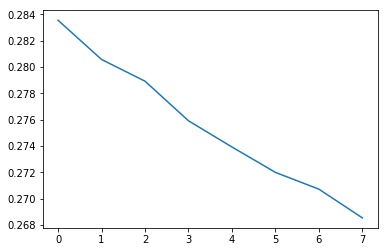

In [317]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(Plots1.loss_valid[1:-1])

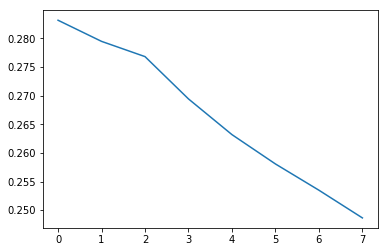

In [318]:
plt.figure()
plt.plot(Plots2.loss_valid[1:-1])

In [228]:
X,Y = generate_batch(15, Data2, Params.seq_len)


hidden = torch.ones(10,150).cuda()
target = onehencode('t',Data2.encoder)

def parse_hidden(x, hidden,Data,symbol='*'):
    new_hidden = copy.deepcopy(hidden.detach())
    for i in range(0,x.shape[0]):
        if onehdecode(x[i,:],Data.decoder) == symbol:
            new_hidden[i,:] = torch.zeros(1,hidden.shape[1])
    return new_hidden

new_hidden = parse_hidden(X[:,4,:],hidden,Data2, symbol='t')
            
            
# new_hidden = copy.deepcopy(x[:,0,:].detach())
# new_hidden = torch.zeros(10,347).cuda()
# for i in range(0,Params2.bsize):
#     val, idx = torch.max(x[i,0,:],0)
#     print(Data2.decoder[idx.item()])
#     if Data2.decoder[idx.item()] == 't':
#         new_hidden[i,:] = torch.zeros(1,347).cuda()
        

#         new_hidden[idx] = x[idx,0,:]

#     target = np.array(onehencode('t',Data2.encoder).cpu())
# x2 = np.array(x.cpu())
# torch.ones(10,347).cuda()

# print(np.where(x2[:,0,:] == target, 0, 1))

# np.array(target)

# new_hidden = torch.where(x[0:5,0,:] == target, torch.zeros(1,347).cuda() ,torch.ones(1,347).cuda())
# print(new_hidden.shape)
# print(new_hidden[:,0:5])

# new_hidden = torch.repeat(new_hidden[0,:])
# new_hidden = torch.mul(hidden, new_hidden)

for idx in range(0,len(new_hidden)):
    print(onehdecode(x[idx,4,:],Data2.decoder))
    print(str(new_hidden[idx,0:10])+'\n------------')



t
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
------------
g
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
------------
d
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
------------
i
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
------------
t
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
------------
a
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
------------


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
------------
a
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
------------
y
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
------------
e
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
------------


In [189]:
def onehdecode(vector, decoder):
    val, idx = torch.max(vector,0)
    return decoder[idx.item()]


In [15]:
x,y = generate_batch(15, Data2, Params.seq_len)
# print(torch.where(x[0][0][:] == onehencode('*',Data2.encoder)))
# print(x[0][0].shape)

In [ ]:
save_checkpoint({
            'epoch': epoch,
            'arch': "1_RNN",
            'state_dict': rnn.state_dict(),
            'hd_sz': rnn.hd_sz,
            'in_sz': rnn.in_sz,
            'out_sz': rnn.out_sz,
            'loss': loss,
            'best_prec1': None,
            'optimizer' : None,
        })

In [ ]:
rnn2, epoch, loss = load_checkpoint(filename='models/checkpoint.pth.tar')
rnn2.cuda()

In [ ]:
print(generate_seq(rnn2, torch.zeros(1,hsize).cuda(),'T',100,m,42))
print(generate_seq(rnn, torch.zeros(1,hsize).cuda(),'T',100,m,42))

### build RNN network with LSTM


### cut input into seq length bits

In [ ]:
data = data[['Open','High','Low','Close']]

In [ ]:
cutoff = 0.2
set_train = data[0:round(len(data)*cutoff)]
set_test  = data[round(len(data)*cutoff):-1]

In [ ]:
# set_train.head()

In [ ]:
input_sz = set_train.shape[1]
hidden_sz = 100
output_sz = 1

In [ ]:
rnn = RNN(input_sz, hidden_sz, output_sz)

In [ ]:
# for index, row in set_train.iterrows():
#     print(np.array(row))

In [ ]:
lr = 0.005

def train(X,Y)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(X.size()[0]):
        output, hidden = rnn(X[i], hidden)
        
    loss = criterion(output, )